## Herbarium samples project (0)

In [1]:
#this notebook only contains filtering steps 

Data README

- genotyped-all.hf.g15mac3.SNPonly_bi_valid.vcf historical samples without duplicates probably filtered
- in_pair_genotyped-all.hf.g15mac3.SNPonly_bi_nuc_valid_biallelic.vcf forget about this file it has duplciates snps
- 1001genomes_snp-short-indel_only_ACGTN.vcf.gz 1001 genomes
- in_pair_1001genomes_snp-short-indel_only_ACGTN_biallelic.vcf 1001g that are present in historical samples
- historical_and_modern_pairs.csv

In [1]:
import allel
import pandas as pd
import numpy as np
import seaborn as sns

I noticed a few things on the vcf files: 

- I noticed there are duplicated position/chromosome in the in_pair_1001genomes_snp-short-indel_only_ACGTN_biallelic.vcf  but not in the 1001genomes_snp-short-indel_only_ACGTN.vcf.gz so i will work with the raw datafile (probably this was an effect of decomposing multiallelic sites)

- Multiallelic sites:
  
I also noticed multiallelic sites in both files. Multiallelic sites can be process in different ways (like decomposing them into biallelic sites), but since we want to have a 1-1 comparison between historical and modern samples it might be better to get rid of them. 

This are the scripts I ran to check for multiallelic sites 

Count multiallleic:

bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\n' 1001genomes_snp-short-indel_only_ACGTN.vcf.gz | \
awk -F'\t' '{ if ($4 ~ /,/) count++ } END { print count }'
1113934

Total vcf file length (excluding header)

zgrep -v '^#' 1001genomes_snp-short-indel_only_ACGTN.vcf.gz | wc -l
12883854

1113934/12883854 =~ 8.6% 

For the historical dataset they were an even smaller portion. 

Filtering to exclude multiallelic sites (same for historic):

bcftools view -m2 -M2 -v snps -Oz -o modern_biallelic_only.vcf.gz \
1001genomes_snp-short-indel_only_ACGTN.vcf.gz

- Also something I noticed is that there a lot of missing sites particularly in the historiacl vcf 

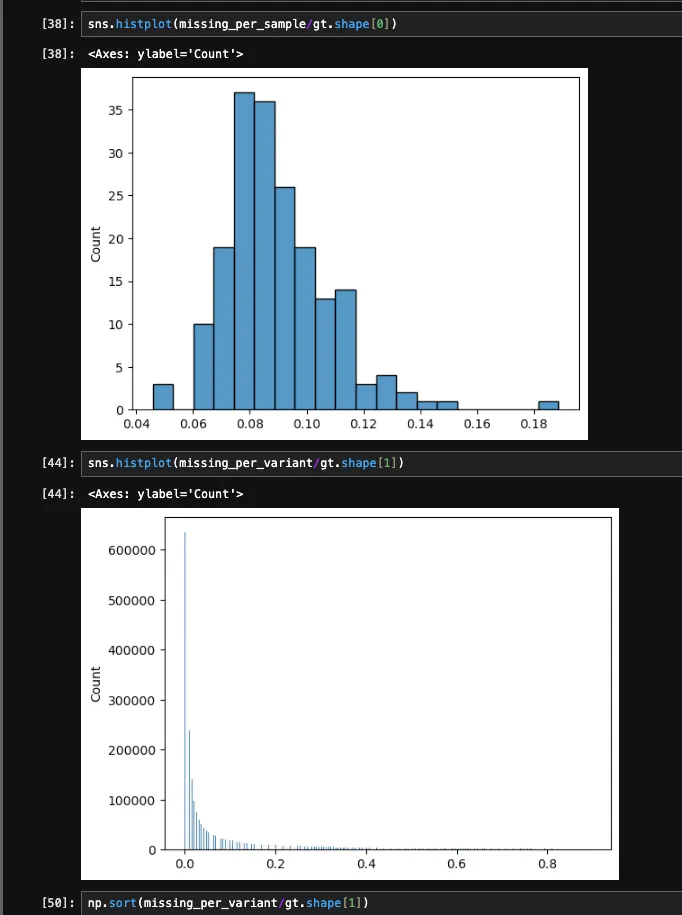!

So I also filtered variants with >10% missing samples (same for modern)

bcftools view -e 'F_MISSING > 0.10' hist.vcf.gz -Oz -o hist_filtered.vcf.gz

After I filtered for missing and multiallelic sites, I collected the unique sites of each vcf to find common positions 

bcftools query -f'%CHROM\t%POS\n' hist_filtered_biallelic_only.vcf.gz > pos_historical.txt

bcftools query -f'%CHROM\t%POS\n' modern_filtered_biallelic_only.vcf.gz > pos_modern.txt


Once I had both position+chromosome I checked the overlap 

In [20]:
## get the sahred positions to then used as filtering 
pos_historical = pd.read_csv('pos_historical.txt',sep = '\t',header=None)

pos_modern = pd.read_csv('pos_modern.txt',sep = '\t',header=None)

shared = pos_modern.merge(pos_historical,how='inner').drop_duplicates()

In [ ]:
## the share positions are more than a million so seems ok

In [21]:
len(shared)

1448536

In [ ]:
## save them 

In [19]:
shared.to_csv("shared_sites.txt", sep="\t", header=False, index=False)

Now that I have the shared positions I will filter both vcfs based on that 

bcftools view -R shared_sites.txt hist_shared_paired_samples.vcf.gz -Oz -o hist_shared_paired_samples_filtered.vcf.gz

bcftools view -R shared_sites.txt modern_shared_paired_samples_filtered.vcf.gz -Oz -o modern_shared_paired_samples_filtered_biallelic.vcf.gz

now I will make sure the samples inf the vcf files correspond to the ones in the 'pairs'

In [ ]:
historical = allel.read_vcf('hist_shared.vcf.gz')
len(historical['samples'])

In [149]:
historical['calldata/GT'].shape

(1879351, 238, 2)

In [ ]:
## make sure the samples are right 

In [4]:
historical_and_modern_pairs = pd.read_csv('historical_and_modern_pairs.csv')

In [151]:
historical_ids = historical_and_modern_pairs['historical_id'].tolist()

In [153]:
len(historical['samples'])

238

In [ ]:
## this needs to be filtered to get the right samples 

In [156]:
pd.Series(historical_ids).to_csv("historical_samples_belongs_to_pairs.txt", index=False, header=False)

filter the right samples 

bcftools view -S historical_samples_belongs_to_pairs.txt -Oz -o hist_shared_paired_samples.vcf.gz hist_shared.vcf.gz

In [157]:
## import filtering by valid samples 
historical = allel.read_vcf('hist_shared_paired_samples.vcf.gz')

In [158]:
## now its correct 
len(historical['samples'])

189

In [ ]:
# same for modern 

In [5]:
modern_ids = historical_and_modern_pairs['modern_id'].tolist()

In [6]:
pd.Series(modern_ids).to_csv("modern_samples_belongs_to_pairs.txt", index=False, header=False)

In [ ]:
# bcftools view -S modern_samples_belongs_to_pairs.txt -Oz -o modern_shared_paired_samples.vcf.gz modern_shared.vcf.gz

In [11]:
len(modern_ids)

189

In [3]:
modern = allel.read_vcf('modern_shared.vcf.gz')

In [9]:
modern['calldata/GT'].shape

(1879351, 1135, 2)